In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train.dtype, y_train.dtype

/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


(torch.uint8, torch.int64)

In [4]:
X_train = X_train.float()
X_test = X_test.float()

In [5]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [6]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [7]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(128)

In [8]:
torch.cuda.is_available()

True

In [9]:
!nvidia-smi

Fri Apr  7 20:52:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0018, -0.0295,  0.0085,  ..., -0.0037,  0.0036,  0.0300],
         [-0.0233, -0.0220, -0.0064,  ...,  0.0115, -0.0324, -0.0158],
         [ 0.0309,  0.0066,  0.0125,  ...,  0.0286,  0.0350, -0.0105]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0321, -0.0053,  0.0045, -0.0211,  0.0224,  0.0130,  0.0158,  0.0272,
          0.0240, -0.0157, -0.0089,  0.0221,  0.0055,  0.0071, -0.0031, -0.0249,
         -0.0334, -0.0024, -0.0124,  0.0129, -0.0047, -0.0190, -0.0051,  0.0227,
          0.0324, -0.0356,  0.0029, -0.0081,  0.0255, -0.0104, -0.0205, -0.0056,
          0.0218, -0.0106,  0.0032,  0.0340, -0.0189, -0.0079, -0.0206, -0.0077,
         -0.0113,  0.0232,  0.0032, -0.0164, -0.0082,  0.0203,

In [11]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [40]:
batch_size = 128

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).cpu().detach().numpy())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().cpu().detach().numpy()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

0.9479
0.9497
0.94939995
0.9486
0.9514
0.951
0.95229995
0.94579995
0.9464
0.9557


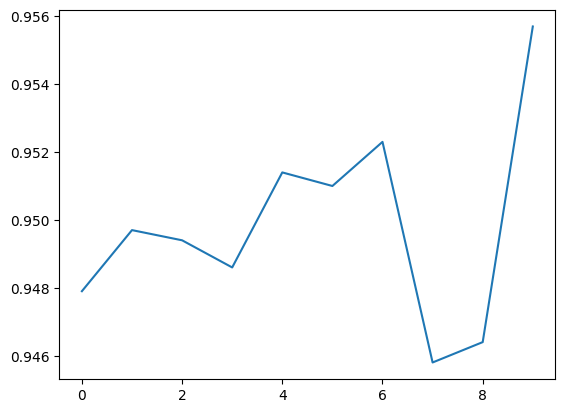

In [41]:
import matplotlib.pyplot as plt
plt.plot(test_accuracy_history)

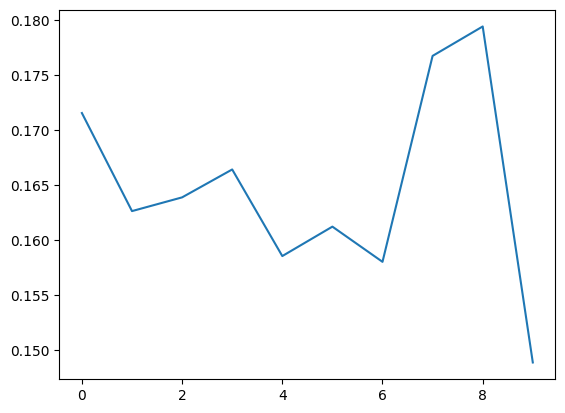

In [42]:
plt.plot(test_loss_history)